<a href="https://colab.research.google.com/github/jmorenohj/Grupo-5-Fairness-in-Crime/blob/main/Model%20%26%20Results/Conteo_de_cr%C3%ADmenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Notebook de procesamiento de datos y generación de gráficas.

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle as pkl
import os
from google.colab import drive
from shapely.geometry import Point,Polygon
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
shared_folder_path = f'/content/drive/Shared drives/Redes Neuronales/Proyecto/Entrega 1/Geoprocesamiento/datos/'
# Listar los archivos
files = os.listdir(shared_folder_path)
for file in files:
    print(file)

chicago_boundaries_income.geojson
chicago_boundaries.geojson
chichago_mascara_zeros.pkl
chichago_mascara_zeros (1).pkl
chichago_mascara_protegidos.pkl
chicago_mascara_localidades.pkl
cuadricula_1km_chicago_planas.geojson
data_chichago_community_planas.geojson
socioeconomic_indicators.tsv
geo_chicago.pkl
data_chicago_opencp.pkl
chicago_community_filtrada_planas.pkl
conteo_de_crímenes.pkl
centroides.pkl


Se filtran las columnas del dataset que no se van a usar, conservando las columnas que nos aportan fecha, ubicación geográfica y tipo de crimen.

In [ ]:
#Preprocesamiento del dataset
file_path = '/content/drive/Shared drives/Redes Neuronales/Proyecto/Entrega 1/Crimes_-_2001_to_Present_20250121.csv'

crimes = pd.read_csv(file_path)
crimes = crimes[['Date','Year','Latitude','Longitude','Primary Type']]
crimes = crimes[crimes['Year'] >= 2020]
crimes['Date'] = pd.to_datetime(crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
crimes['Date'] = crimes['Date'].dt.strftime('%m/%d/%Y')
crimes = crimes[crimes['Primary Type'].isin(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE'])]
crimes.query("(`Primary Type`.notnull()) and (Latitude.notnull()) and (Longitude.notnull()) "
                   , engine='python'
                   , inplace=True)

crimes.drop('Year',axis=1, inplace=True)
crimes.reset_index(drop=True, inplace=True)

In [ ]:
crimes['Date'] = pd.to_datetime(crimes['Date'])
crimes = crimes[(crimes['Date']>='2024-11-29') & (crimes['Date']<='2024-12-27')]
crimes.sort_values(by='Date')

,Date,Latitude,Longitude,Primary Type
119419,2024-11-29,41.924289,-87.635791,THEFT
119628,2024-11-29,41.913505,-87.786771,THEFT
119627,2024-11-29,41.751620,-87.648918,THEFT
119626,2024-11-29,41.778402,-87.695811,THEFT
119625,2024-11-29,41.891679,-87.627552,THEFT
...,...,...,...,...
128601,2024-12-27,41.875255,-87.627619,THEFT
128600,2024-12-27,41.865145,-87.624099,BATTERY
128599,2024-12-27,41.913083,-87.693403,CRIMINAL DAMAGE
128605,2024-12-27,41.884227,-87.651445,THEFT


Se trabajará con un conjunto de datos que secciona la ciudad en comunidades y etiqueta dichas comunidades con las etiquetas de protegido y desprotegido.
Las comunidades desprotegidas son aquellas cuyo ingreso promedio por ciudadano está por debajo de cierto umbral.

In [ ]:
#Distritos protegidos se pasan a coordenadas normales
protectedData = gpd.read_file(shared_folder_path+'chicago_boundaries_income.geojson')
protectedData['protected'] = protectedData['protected'].map({'Unprotected':0,'Protected':1})
protectedData.crs = 'EPSG:4326'
protectedDataEPSG = protectedData.to_crs(epsg=26971)
protectedData

,community,income,protected,geometry
0,DOUGLAS,23791,0,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,19252,1,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,10432,1,"MULTIPOLYGON (((-87.6288 41.80189, -87.62879 4..."
3,GRAND BOULEVARD,23472,0,"MULTIPOLYGON (((-87.60671 41.81681, -87.6067 4..."
4,KENWOOD,35911,0,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...,...,...
72,MOUNT GREENWOOD,34381,0,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MORGAN PARK,27149,0,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,OHARE,25828,0,"MULTIPOLYGON (((-87.83658 41.9864, -87.83658 4..."
75,EDGEWATER,33385,0,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


La ciudad se divide en cuadrículas de 1km x 1km con el objetivo de aportarle granularidad al estudio. Para asignarles el valor de protegido o desprotegido, se usa el dataset anteriormente mencionado.

In [ ]:
#Asignación de protegido a la cuadrícula

cuadricula_1km = gpd.read_file(shared_folder_path+'cuadricula_1km_chicago_planas.geojson')
cuadricula_1km['centroid'] = cuadricula_1km['geometry'].centroid
cuadricula_1km['centroid'] = cuadricula_1km['centroid'].apply(lambda point: Point(round(point.x, 3), round(point.y, 3)))

for square_index, square in cuadricula_1km.iterrows():

    for community_index, community in protectedDataEPSG.iterrows():
        if community['geometry'].contains(square['centroid']):
            cuadricula_1km.at[square_index,'protected'] = community['protected']

cuadricula_1km = cuadricula_1km.dropna(subset=['protected'])

cuadricula_1km.reset_index(drop=True, inplace=True)


cuadricula_1km

,geometry,centroid,protected
0,"POLYGON ((359577.325 552875.354, 359577.325 55...",POINT (360077.325 553375.354),1.0
1,"POLYGON ((360577.325 552875.354, 360577.325 55...",POINT (361077.325 553375.354),1.0
2,"POLYGON ((361577.325 552875.354, 361577.325 55...",POINT (362077.325 553375.354),1.0
3,"POLYGON ((362577.325 552875.354, 362577.325 55...",POINT (363077.325 553375.354),0.0
4,"POLYGON ((363577.325 552875.354, 363577.325 55...",POINT (364077.325 553375.354),0.0
...,...,...,...
596,"POLYGON ((354577.325 592875.354, 354577.325 59...",POINT (355077.325 593375.354),0.0
597,"POLYGON ((351577.325 593875.354, 351577.325 59...",POINT (352077.325 594375.354),0.0
598,"POLYGON ((352577.325 593875.354, 352577.325 59...",POINT (353077.325 594375.354),0.0
599,"POLYGON ((353577.325 593875.354, 353577.325 59...",POINT (354077.325 594375.354),0.0


In [ ]:
#Se calcula la latitud y longitud de los centroides
cuadriculaEPSG = cuadricula_1km.to_crs(epsg=4326)
cuadriculaEPSG['Latitude'] = cuadriculaEPSG.centroid.y
cuadriculaEPSG['Longitude'] = cuadriculaEPSG.centroid.x
cuadricula_1km['Latitude'] = cuadriculaEPSG['Latitude']
cuadricula_1km['Longitude'] = cuadriculaEPSG['Longitude']
cuadriculaEPSG = cuadriculaEPSG.drop(columns=['geometry','centroid','protected'])
print(cuadriculaEPSG)

      Latitude  Longitude
0    41.649054 -87.612140
1    41.648978 -87.600136
2    41.648901 -87.588133
3    41.648823 -87.576129
4    41.648743 -87.564126
..         ...        ...
596  42.009533 -87.668442
597  42.018740 -87.704567
598  42.018673 -87.692494
599  42.018605 -87.680421
600  42.018536 -87.668348

[601 rows x 2 columns]


In [ ]:
cuadricula_1km

,geometry,centroid,protected,Latitude,Longitude
0,"POLYGON ((359577.325 552875.354, 359577.325 55...",POINT (360077.325 553375.354),1.0,41.649054,-87.612140
1,"POLYGON ((360577.325 552875.354, 360577.325 55...",POINT (361077.325 553375.354),1.0,41.648978,-87.600136
2,"POLYGON ((361577.325 552875.354, 361577.325 55...",POINT (362077.325 553375.354),1.0,41.648901,-87.588133
3,"POLYGON ((362577.325 552875.354, 362577.325 55...",POINT (363077.325 553375.354),0.0,41.648823,-87.576129
4,"POLYGON ((363577.325 552875.354, 363577.325 55...",POINT (364077.325 553375.354),0.0,41.648743,-87.564126
...,...,...,...,...,...
596,"POLYGON ((354577.325 592875.354, 354577.325 59...",POINT (355077.325 593375.354),0.0,42.009533,-87.668442
597,"POLYGON ((351577.325 593875.354, 351577.325 59...",POINT (352077.325 594375.354),0.0,42.018740,-87.704567
598,"POLYGON ((352577.325 593875.354, 352577.325 59...",POINT (353077.325 594375.354),0.0,42.018673,-87.692494
599,"POLYGON ((353577.325 593875.354, 353577.325 59...",POINT (354077.325 594375.354),0.0,42.018605,-87.680421


Se procede a contar la cantidad de crimenes de tipo Theft, Battery y Criminal Damage que ocurren por cuadro durante cada día. Esto podrá permitir calcular una probabilidad de ocurrencia de los respectivos crímenes dependiendo de la zona y del día de la semana.

In [ ]:
def count_crimes(data):
    #Transformación de coordenadas
    geometria=[ Point(crimes['Longitude'].iloc[i],crimes['Latitude'].iloc[i]) for i in range(len(data))]
    geo_pandas_chic=gpd.GeoDataFrame(data=crimes,geometry=geometria)
    geo_pandas_chic.crs = 'EPSG:4326'
    geo_pandas_chic_planas = geo_pandas_chic.to_crs(epsg=26971)
    geo_pandas_chic_planas['coord_x']=geo_pandas_chic_planas.geometry.apply(lambda x: x.x)
    geo_pandas_chic_planas['coord_y']=geo_pandas_chic_planas.geometry.apply(lambda x: x.y)

    #Cálculo de mínimos valores de cuadrícula para calcular los centros
    minx = 1e10
    miny = 1e10
    for index, row in cuadricula_1km.iterrows():
        coords = list(cuadricula_1km['geometry'].iloc[index].exterior.coords)
        for point in coords:
            if point[0]<minx:
                minx = point[0]
            if point[1]<miny:
                miny = point[1]


    #Mapeo de posiciones para acelerar búsquedas
    map_positions = {}
    for index, square in cuadricula_1km.iterrows():
        map_positions[square['centroid']] = index


    #Creación de nuevo dataframe
    crimes_count = pd.DataFrame(columns=['Date', 'Latitude','Longitude','protected','BATTERY probability','CRIMINAL DAMAGE probability','THEFT probability'])
    crimes_count.set_index(['Date', 'Latitude', 'Longitude'], inplace=True)
    crimes_count = crimes_count.fillna(0)


    #Conteo de crímenes
    for crime_index, crime in geo_pandas_chic_planas.iterrows():
        centroid = Point(round(minx+((crime['coord_x']-minx)//1000)*1000+500,3),round(miny+((crime['coord_y']-miny)//1000)*1000+500,3))
        if centroid not in map_positions:
            continue

        square = cuadricula_1km.iloc[map_positions[centroid]]
        key = (crime['Date'],square['Latitude'],square['Longitude'])
        if key in crimes_count.index:
            crimes_count.loc[key, 'protected'] = square['protected']
            crimes_count.loc[key, crime['Primary Type']+" probability"] += 1
        else:
            crimes_count.loc[key, crime['Primary Type']+" probability"] = 1
            crimes_count.loc[key] = crimes_count.loc[key].fillna(0)


    #Normalización del conteo de crímenes
    columns_to_normalize = ['BATTERY probability','CRIMINAL DAMAGE probability','THEFT probability']
    data_to_normalize = crimes_count[columns_to_normalize]
    row_sums = data_to_normalize.sum(axis=1)
    normalized_data = data_to_normalize.div(row_sums, axis=0)
    crimes_count[columns_to_normalize] = normalized_data


    #Día de la semana y semana del año
    dates = pd.to_datetime(crimes_count.index.get_level_values('Date'))
    crimes_count['week'] = dates.isocalendar().week.values
    crimes_count['day_of_week'] = dates.weekday.values
    crimes_count = crimes_count.reset_index()
    return crimes_count

In [ ]:
tabla = count_crimes(crimes)

tabla

,Date,Latitude,Longitude,protected,BATTERY probability,CRIMINAL DAMAGE probability,THEFT probability,week,day_of_week
0,2024-11-29,41.928294,-87.633116,0.0,0.0,0.0,1.0,48,4
1,2024-11-29,41.775020,-87.598702,1.0,0.0,0.333333,0.666667,48,4
2,2024-11-29,41.973452,-87.656752,0.0,0.0,0.0,1.0,48,4
3,2024-11-29,41.875008,-87.766210,1.0,0.0,1.0,0.0,48,4
4,2024-11-29,41.865757,-87.718113,0,0.0,0.0,1.0,48,4
...,...,...,...,...,...,...,...,...,...
5867,2024-12-27,41.883951,-87.754083,0,0.0,0.0,1.0,52,4
5868,2024-12-27,41.748236,-87.635076,0,0.0,0.0,1.0,52,4
5869,2024-12-27,41.685694,-87.719831,0,1.0,0.0,0.0,52,4
5870,2024-12-27,41.856754,-87.718199,0,0.0,1.0,0.0,52,4


In [ ]:
tabla[(tabla['THEFT probability']>0.0) & (tabla['BATTERY probability']>0.0) &  (tabla['CRIMINAL DAMAGE probability']>0.0) ]

,Date,Latitude,Longitude,protected,BATTERY probability,CRIMINAL DAMAGE probability,THEFT probability,week,day_of_week
80,2024-11-29,41.883280,-87.633608,0.0,0.4,0.2,0.4,48,4
201,2024-11-30,41.892954,-87.754002,1.0,0.333333,0.333333,0.333333,48,5
214,2024-11-30,41.883424,-87.657702,0.0,0.2,0.2,0.6,48,5
293,2024-11-30,41.982455,-87.656657,0.0,0.333333,0.333333,0.333333,48,5
404,2024-12-01,41.883280,-87.633608,0.0,0.25,0.125,0.625,48,6
...,...,...,...,...,...,...,...,...,...
5698,2024-12-27,41.884011,-87.766131,1.0,0.6,0.2,0.2,52,4
5714,2024-12-27,41.883206,-87.621560,0.0,0.5,0.125,0.375,52,4
5719,2024-12-27,41.901285,-87.633411,0.0,0.25,0.25,0.5,52,4
5728,2024-12-27,41.892283,-87.633510,0.0,0.333333,0.166667,0.5,52,4


In [ ]:
data_path = f'/content/drive/Shared drives/Redes Neuronales/Proyecto/Entrega 1/Geoprocesamiento/datos del modelo/'
# Listar los archivos
files = os.listdir(data_path)
for file in files:
    print(file)

semana5.pkl
semana6.pkl
semana7.pkl
semana8.pkl
Modelo_final.ipynb


A continuacón, se cargan los resultados obtenidos por el modelo. El modelo generó la probabilidad de ocurrencia de los tres crímenes con respecto a cada cuadro de la cuadrícula y día de la semana.

In [ ]:
from datetime import timedelta
semana5 = pkl.load(open(data_path+'semana5.pkl', "rb"))
semana6 = pkl.load(open(data_path+'semana5.pkl', "rb"))
semana7 = pkl.load(open(data_path+'semana5.pkl', "rb"))
semana8 = pkl.load(open(data_path+'semana5.pkl', "rb"))


fecha_base5 = pd.Timestamp('2024-11-29')
fecha_base6 = pd.Timestamp('2024-12-06')
fecha_base7 = pd.Timestamp('2024-12-13')
fecha_base8 = pd.Timestamp('2024-12-20')

semana5['Date'] = semana5['day_of_week'].apply(lambda x: fecha_base5 + timedelta(days=x))
semana6['Date'] = semana6['day_of_week'].apply(lambda x: fecha_base6 + timedelta(days=x))
semana7['Date'] = semana7['day_of_week'].apply(lambda x: fecha_base7 + timedelta(days=x))
semana8['Date'] = semana8['day_of_week'].apply(lambda x: fecha_base8 + timedelta(days=x))
semanas = resultado = pd.concat([semana5, semana6,semana7,semana8])
semanas

,Latitude,Longitude,day_of_week,THEFT probability,BATTERY probability,CRIMINAL DAMAGE probability,Date
0,41.649054,-87.612140,0,0.311311,0.384887,0.303802,2024-11-29
1,41.648978,-87.600136,0,0.313669,0.385756,0.300575,2024-11-29
2,41.648901,-87.588133,0,0.316012,0.386567,0.297421,2024-11-29
3,41.648823,-87.576129,0,0.318338,0.387322,0.294340,2024-11-29
4,41.648743,-87.564126,0,0.320646,0.388019,0.291336,2024-11-29
...,...,...,...,...,...,...,...
4202,42.009533,-87.668442,6,0.416909,0.348559,0.234532,2024-12-26
4203,42.018740,-87.704567,6,0.417198,0.345615,0.237187,2024-12-26
4204,42.018673,-87.692494,6,0.418462,0.346135,0.235403,2024-12-26
4205,42.018605,-87.680421,6,0.419698,0.346642,0.233661,2024-12-26


In [ ]:
import numpy as np

def calcular_mse(y_real, y_pred):
    return np.mean((np.array(y_real) - np.array(y_pred)) ** 2)


La idea de este notebook es hacer la comparación del error obtenido en las áreas protegidas con respecto a las áreas desprotegidas. Para ello se procede a calcular el error cuadrático medio obtenido por parte de la salida del modelo con respecto a los datos reales ya procesados.

In [ ]:
merged_df = pd.merge(tabla, semanas, on=['Date', 'Latitude', 'Longitude'], suffixes=('_real', '_pred'), how='left')
start_date = '2024-11-29'
end_date = '2024-12-26'

# Create a date range and iterate over it
date_range = pd.date_range(start=start_date, end=end_date)

error = pd.DataFrame(columns=['Date','BATTERY PROTECTED','BATTERY UNPROTECTED', 'DIFF BATTERY','CRIMINAL DAMAGE PROTECTED','CRIMINAL DAMAGE UNPROTECTED','DIFF CRIMINAL DAMAGE','THEFT PROTECTED','THEFT UNPROTECTED', 'DIFF THEFT'])
error.set_index(['Date'], inplace=True)
for date in date_range:
    dateDf = merged_df[(merged_df['Date']==date) & (merged_df['protected']==1)]
    error.loc[date, 'BATTERY PROTECTED'] = calcular_mse(dateDf['BATTERY probability_real'].tolist(),dateDf['BATTERY probability_pred'].tolist())
    error.loc[date, 'CRIMINAL DAMAGE PROTECTED'] = calcular_mse(dateDf['CRIMINAL DAMAGE probability_real'].tolist(),dateDf['CRIMINAL DAMAGE probability_pred'].tolist())
    error.loc[date, 'THEFT PROTECTED'] = calcular_mse(dateDf['THEFT probability_real'].tolist(),dateDf['THEFT probability_pred'].tolist())
    dateDf = merged_df[(merged_df['Date']==date) & (merged_df['protected']==0)]
    error.loc[date, 'BATTERY UNPROTECTED'] = calcular_mse(dateDf['BATTERY probability_real'].tolist(),dateDf['BATTERY probability_pred'].tolist())
    error.loc[date, 'CRIMINAL DAMAGE UNPROTECTED'] = calcular_mse(dateDf['CRIMINAL DAMAGE probability_real'].tolist(),dateDf['CRIMINAL DAMAGE probability_pred'].tolist())
    error.loc[date, 'THEFT UNPROTECTED'] = calcular_mse(dateDf['THEFT probability_real'].tolist(),dateDf['THEFT probability_pred'].tolist())
error['DIFF BATTERY'] = error['BATTERY UNPROTECTED'] - error['BATTERY PROTECTED']
error['DIFF CRIMINAL DAMAGE'] = error['CRIMINAL DAMAGE UNPROTECTED'] - error['CRIMINAL DAMAGE PROTECTED']
error['DIFF THEFT'] = error['THEFT UNPROTECTED'] - error['THEFT PROTECTED']
error = error.reset_index()
error

,Date,BATTERY PROTECTED,BATTERY UNPROTECTED,DIFF BATTERY,CRIMINAL DAMAGE PROTECTED,CRIMINAL DAMAGE UNPROTECTED,DIFF CRIMINAL DAMAGE,THEFT PROTECTED,THEFT UNPROTECTED,DIFF THEFT
0,2024-11-29,0.11847,0.185286,0.066816,0.088639,0.136637,0.047998,0.098614,0.233888,0.135274
1,2024-11-30,0.140708,0.196897,0.056189,0.122291,0.151373,0.029082,0.107197,0.235415,0.128218
2,2024-12-01,0.117349,0.234994,0.117646,0.077764,0.15507,0.077306,0.114298,0.198344,0.084046
3,2024-12-02,0.114722,0.18517,0.070448,0.059763,0.151204,0.091441,0.095575,0.242892,0.147317
4,2024-12-03,0.127736,0.193815,0.066078,0.109361,0.139383,0.030022,0.131332,0.236011,0.104679
5,2024-12-04,0.098029,0.203949,0.105921,0.081887,0.15286,0.070974,0.153172,0.247175,0.094003
6,2024-12-05,0.111521,0.188164,0.076643,0.094687,0.155432,0.060744,0.101591,0.257875,0.156284
7,2024-12-06,0.119982,0.205648,0.085666,0.080237,0.128217,0.04798,0.107282,0.23649,0.129207
8,2024-12-07,0.098306,0.177621,0.079316,0.073302,0.160555,0.087253,0.134957,0.204101,0.069144
9,2024-12-08,0.092066,0.20043,0.108364,0.139573,0.184923,0.04535,0.091736,0.19326,0.101524


A continuación se presentan las gráficas obtenidas de los datos. Con respecto a los tres tipos de robos, se puede observar que el error del modelo prediciendo probabilidades de robo en zonas desprotegidas es mayor, demostrando así que el modelo cuenta con un sesgo hacia las poblaciones desprotegidas.

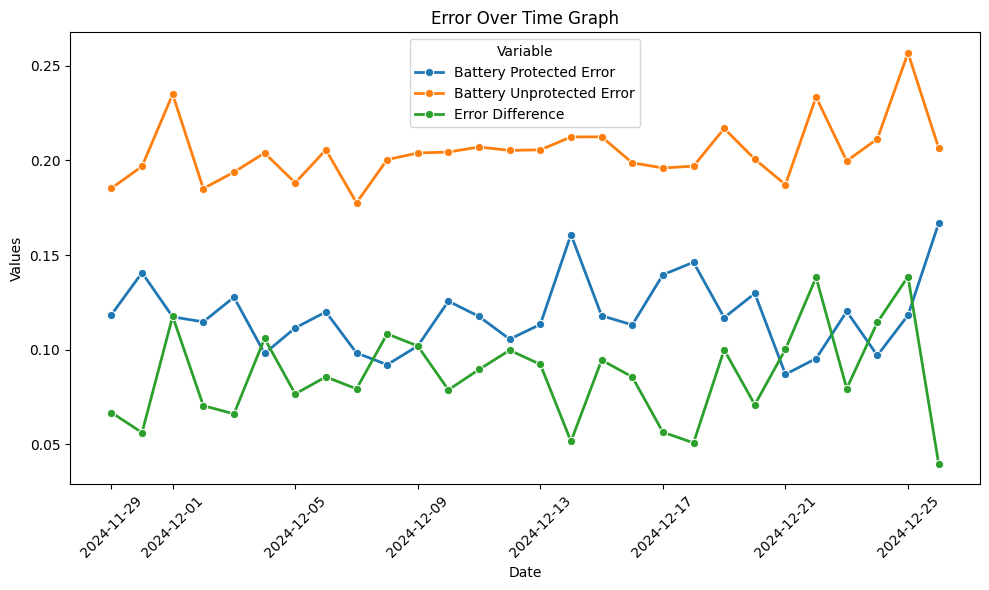

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convertir el DataFrame de formato ancho a largo
df_long = error.melt(id_vars=['Date'], value_vars=['BATTERY PROTECTED', 'BATTERY UNPROTECTED', 'DIFF BATTERY'],
                  var_name='Variable', value_name='Value')

# Crear la gráfica con seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='Date', y='Value', hue='Variable',marker='o',ci=None, linewidth=2)
plt.legend(title='Variable', labels=['Battery Protected Error', 'Battery Unprotected Error', 'Error Difference'])

# Personalizar la gráfica
plt.title('Error Over Time Graph')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotar las fechas para que se lean mejor
plt.tight_layout()  # Ajustar el espaciado
plt.savefig('BATTERY_Error.png', dpi=300)
# Mostrar la gráfica
plt.show()

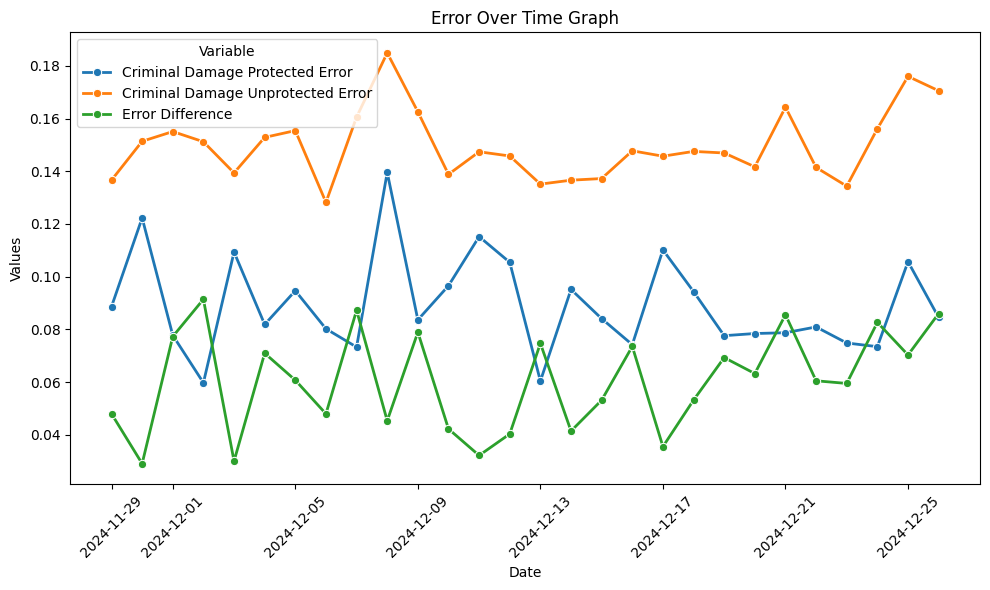

In [ ]:
# Convertir el DataFrame de formato ancho a largo
df_long = error.melt(id_vars=['Date'], value_vars=['CRIMINAL DAMAGE PROTECTED', 'CRIMINAL DAMAGE UNPROTECTED', 'DIFF CRIMINAL DAMAGE'],
                  var_name='Variable', value_name='Value')

# Crear la gráfica con seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='Date', y='Value', hue='Variable', marker='o',ci=None, linewidth=2)

plt.legend(title='Variable', labels=['Criminal Damage Protected Error', 'Criminal Damage Unprotected Error', 'Error Difference'])
# Personalizar la gráfica
plt.title('Error Over Time Graph')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotar las fechas para que se lean mejor
plt.tight_layout()  # Ajustar el espaciado
plt.savefig('CRIMINAL_DAMAGE_Error.png', dpi=300)
# Mostrar la gráfica
plt.show()

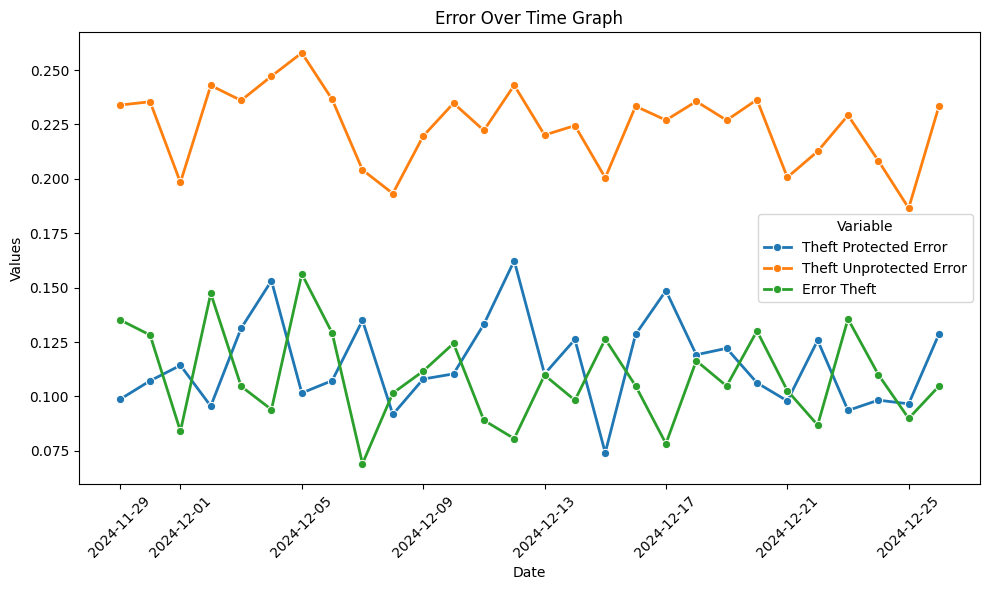

In [ ]:
# Convertir el DataFrame de formato ancho a largo
df_long = error.melt(id_vars=['Date'], value_vars=['THEFT PROTECTED', 'THEFT UNPROTECTED', 'DIFF THEFT'],
                  var_name='Variable', value_name='Value')

# Crear la gráfica con seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='Date', y='Value', hue='Variable', marker='o',ci=None, linewidth=2)
plt.legend(title='Variable', labels=['Theft Protected Error', 'Theft Unprotected Error', 'Error Theft'])
# Personalizar la gráfica
plt.title('Error Over Time Graph')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotar las fechas para que se lean mejor
plt.tight_layout()  # Ajustar el espaciado
plt.savefig('THEFT_Error.png', dpi=300)
# Mostrar la gráfica
plt.show()